# Atmospheric Retrievals with POSEIDON

At long last, your proposal to observe the newly discovered hot Jupiter WASP-999b with the *Hubble Space Telescope* has been accepted. Congratulations! 

### Loading Data

Months later, after carefully reducing the observations, you are ready to gaze in awe at your transmission spectrum.

First, you load all the usual stellar and planetary properties for this system.

In [1]:
from POSEIDON.core import create_star, create_planet
from POSEIDON.constants import R_Sun, R_J

#***** Define stellar properties *****#

R_s = 1.155*R_Sun     # Stellar radius (m)
T_s = 6071.0          # Stellar effective temperature (K)
Met_s = 0.0           # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.38        # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s)

#***** Define planet properties *****#

planet_name = 'WASP-999b'  # Planet name used for plots, output files etc.

R_p = 1.359*R_J     # Planetary radius (m)
g_p = 9.186         # Gravitational field of planet (m/s^2)
T_eq = 1400.0       # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, gravity = g_p, T_eq = T_eq)

Next, you plot your observed transmission spectrum of WASP-999b.

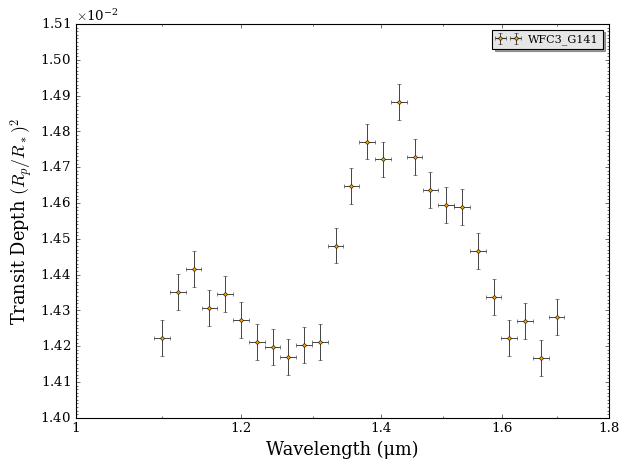

In [2]:
from POSEIDON.core import load_data, wl_grid_constant_R
from POSEIDON.visuals import plot_data

#***** Model wavelength grid *****#

wl_min = 0.4      # Minimum wavelength (um)
wl_max = 1.8      # Maximum wavelength (um)
R = 4000          # Spectral resolution of grid      

# We need to provide a model wavelength grid to initialise instrument properties
wl = wl_grid_constant_R(wl_min, wl_max, R)

#***** Specify data location and instruments  *****#

data_dir = 'Tutorial'                   # Special directory for this tutorial
datasets = ['WASP-999b_WFC3_G141.dat']  # Found in reference_data/observations
instruments = ['WFC3_G141']             # Instruments corresponding to the data

# Load dataset, pre-load instrument PSF and transmission function
data = load_data(data_dir, datasets, instruments, wl)

# Plot our data
fig_data = plot_data(data, planet)

The spectrum isn't flat! 🎉

Even better, your long term collaborator Dr. Tenalp just so happens to also have some observations of WASP-999b at shorter wavelengths. Let's add their Hubble STIS data to our collection.

<div class="alert alert-info">

  **Note:**

  The data file format expected by POSEIDON is:

  wavelength (μm) | bin half width (μm) | transit depth $(R_p/R_s)^2$ | transit depth error
</div>

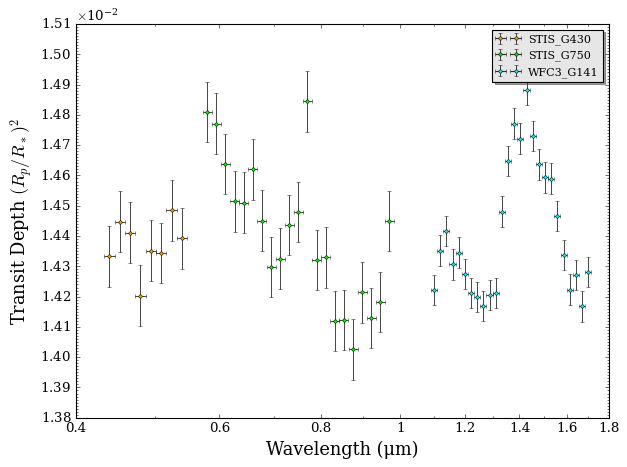

In [3]:
# Specify the STIS and WFC3 Hubble data
data_dir = 'Tutorial'                   
datasets = ['WASP-999b_STIS_G430.dat', 
            'WASP-999b_STIS_G750.dat', 
            'WASP-999b_WFC3_G141.dat']  
instruments = ['STIS_G430', 'STIS_G750', 'WFC3_G141']

# Load dataset, pre-load instrument PSF and transmission function
data = load_data(data_dir, datasets, instruments, wl)

# Plot our data
fig_data = plot_data(data, planet)

With data in hand, you are ready to begin the process of retrieving WASP-999b's atmospheric properties.

### Creating a Retrieval Model

Now comes the creative part: what model do you try first to fit WASP-999b's transmission spectrum?

Given the a priori known low density of the planet, you conclude it is reasonable to assume this is a giant planet dominated by H$_2$ and He. Looking at your data above, especially the **huge** absorption feature in the infrared around 1.4 μm, you guess that H$_2$O could be present (based on theoretical predictions or after looking up its cross section).

So for a first attempt, you consider a model with H$_2$O, an isothermal temperature profile, and no clouds.

In [4]:
from POSEIDON.core import define_model

#***** Define model *****#

model_name = 'My_first_retrieval'  # Model name used for plots, output files etc.

bulk_species = ['H2', 'He']     # H2 + He comprises the bulk atmosphere
param_species = ['H2O']         # The only trace gas is H2O

# Create the model object
model = define_model(model_name, bulk_species, param_species, 
                     PT_profile = 'isotherm', cloud_model = 'cloud-free')

# Check the free parameters defining this model
print("Free parameters: " + str(model['param_names']))

Free parameters: ['T' 'R_p_ref' 'log_H2O']


### Setting Retrieval Priors

One of the most important aspects in any Bayesian analysis is deciding what priors to use for the free parameters. Specifying a prior has two steps: (i) choosing the type of probability distribution; and (ii) choosing the allowable range.

Most free parameters in atmospheric retrievals with POSEIDON use the following prior types:

- Uniform: you provide the minimum and maximum values for the parameter.
- Gaussian: you provide the mean and standard deviation for the parameter.

<div class="alert alert-info">

  **Note:**

  If you do not specify a prior type or range for a given parameter, POSEIDON will ascribe a default prior type (generally uniform) and a 'generous' range.

</div>

**Priors for WASP-999b**

Your first retrieval is defined by three free parameters: (1) the isothermal atmospheric temperature; (2) the radius at the (fixed) reference pressure; and (3) the log-mixing ratio of H$_2$O. Since you don't have any *a priori* information on WASP-999b's atmosphere, you decide to use uniform priors for the three parameters. 

You think a reasonable prior range for the temperature of this hot Jupiter is $400 \, \rm{K}$ to $(T_{\rm{eq}} + 200 \, \rm{K}) = 1600 \, \rm{K}$. For the reference radius, you choose a wide range from 85\% to 115% of the observed white light radius. Finally, for the H$_2$O abundance you ascribe a very broad range from $10^{-12}$ to 0.1. 

In [5]:
from POSEIDON.core import set_priors

#***** Set priors for retrieval *****#

# Initialise prior type dictionary
prior_types = {}

# Specify whether priors are linear, Gaussian, etc.
prior_types['T'] = 'uniform'
prior_types['R_p_ref'] = 'uniform'
prior_types['log_H2O'] = 'uniform'

# Initialise prior range dictionary
prior_ranges = {}

# Specify prior ranges for each free parameter
prior_ranges['T'] = [400, 1600]
prior_ranges['R_p_ref'] = [0.85*R_p, 1.15*R_p]
prior_ranges['log_H2O'] = [-12, -1]

# Create prior object for retrieval
priors = set_priors(planet, star, model, data, prior_types, prior_ranges)

### Pre-load Opacities

The last step before running a retrieval is to pre-interpolate the cross sections for our model and store them in memory. For more details on this process, see the forward model tutorial.

<div class="alert alert-warning">

  **Warning:**

  Ensure the range of $T_{\rm{fine}}$ used for opacity pre-interpolation is at least as large as the desired prior range for temperatures to be explored in the retrieval. Any models with layer temperatures falling outside the range of $T_{\rm{fine}}$ will be automatically rejected (for retrievals with non-isothermal P-T profiles, this prevents unphysical profiles with negative temperatures etc.)

</div>




In [6]:
from POSEIDON.core import read_opacities
import numpy as np

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# Define fine temperature grid (K)
T_fine_min = 400     # Same as prior range for T
T_fine_max = 1600    # Same as prior range for T
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

# Pre-interpolate the opacities
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H2O done
Opacity pre-interpolation complete.


### Run Retrieval

You are now ready to run your first atmospheric retrieval!

Here we will use the nested sampling algorithm MultiNest to explore the parameter space. The key input quantity you need to provide to MultiNest is called the *number of live points*, $N_{\rm{live}}$, which determines how finely the parameter space will be sampled (and hence the number of computed spectra). For exploratory retrievals, $N_{\rm{live}} = 400$ usually suffices. For publication-quality results, $N_{\rm{live}} = 2000$ is reasonable. 

This simple POSEIDON retrieval should take about 10 minutes on 1 core for a typical laptop.

<div class="alert alert-info">

  **Tip:**

  Retrievals run faster on multiple cores. When running the cells in this Jupyter notebook, only a single core will be used. You can run a multi-core retrieval on 4 cores by converting this Jupyter notebook into a python script, then calling mpirun on the .py file:

  ```
  mpirun -n 4 python -u YOUR_RETRIEVAL_SCRIPT.py
  ```
  
</div>

In [7]:
from POSEIDON.retrieval import run_retrieval

#***** Specify fixed atmospheric settings for retrieval *****#

# Atmospheric pressure grid
P_min = 1.0e-7    # 0.1 ubar
P_max = 100       # 100 bar
N_layers = 100    # 100 layers

# Let's space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure
P_ref = 10.0   # Retrieved R_p_ref parameter will be the radius at 10 bar

#***** Run atmospheric retrieval *****#

run_retrieval(planet, star, model, opac, data, priors, wl, P, P_ref, R = R, 
              spectrum_type = 'transmission', sampling_algorithm = 'MultiNest', 
              N_live = 400, verbose = True)


POSEIDON now running 'My_first_retrieval'
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    3
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.984683
Replacements:                                450
Total Samples:                               457
Nested Sampling ln(Z):            -113674.727734
Acceptance Rate:                        0.956023
Replacements:                                500
Total Samples:                               523
Nested Sampling ln(Z):             -71492.270832
Acceptance Rate:                        0.925926
Replacements:                                550
Total Samples:                               594
Nested Sampling ln(Z):             -55423.475901
Acceptance Rate:                        0.894188
R

Now that the retrieval is finished, you're eager and ready to see what WASP-999b's atmosphere is hiding. 

You first plot confidence intervals of the retrieved spectrum from this model compared to WASP-999b's observed transmission spectrum. You also generate a corner plot showing the retrieved probability distributions of the model parameters.

Generating corner plot ...


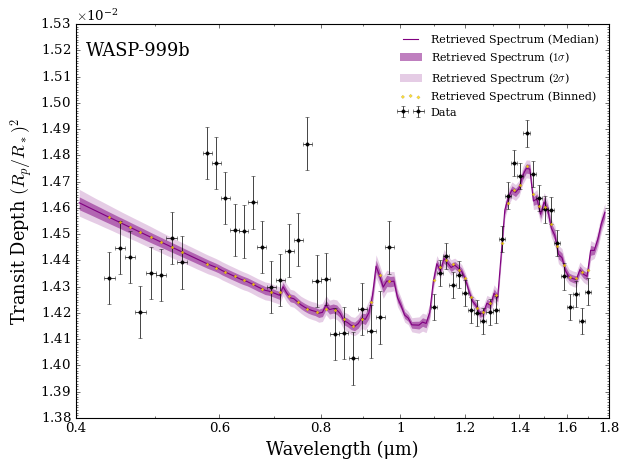

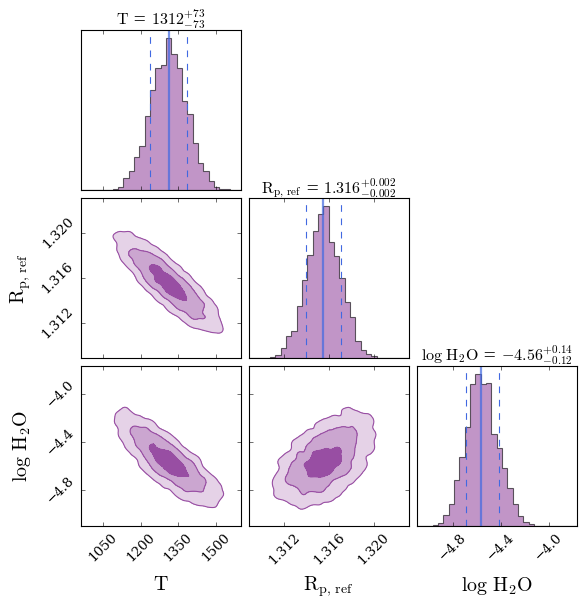

In [8]:
from POSEIDON.utility import read_retrieved_spectrum, plot_collection
from POSEIDON.visuals import plot_spectra_retrieved
from POSEIDON.corner import generate_cornerplot

#***** Plot retrieved transmission spectrum *****#

# Read retrieved spectrum confidence regions
wl, spec_low2, spec_low1, spec_median, \
spec_high1, spec_high2 = read_retrieved_spectrum(planet_name, model_name)

# Create composite spectra objects for plotting
spectra_median = plot_collection(spec_median, wl, collection = [])
spectra_low1 = plot_collection(spec_low1, wl, collection = []) 
spectra_low2 = plot_collection(spec_low2, wl, collection = []) 
spectra_high1 = plot_collection(spec_high1, wl, collection = []) 
spectra_high2 = plot_collection(spec_high2, wl, collection = [])

# Produce figure
fig_spec = plot_spectra_retrieved(spectra_median, spectra_low2, spectra_low1, 
                                  spectra_high1, spectra_high2, planet_name,
                                  data, R_to_bin = 100)

#***** Make corner plot *****#

fig_corner = generate_cornerplot(planet, model)


Not bad for a first simple model! The fit to the infrared WFC3 data looks reasonable, but there is considerable scatter in the visible wavelength data which isn't captured by the model. You quantitatively assess the fit quality by opening the retrieval results file.

<div class="alert alert-info">

  **Tip:**

  Retrieval results are automatically created in the POSEIDON output directory:

  ```
  ./POSEIDON_output/*planet_name*/retrievals/results

  ```
  
  There, you will find 5 files for each retrieval:

  1. **'corner.pdf'** - the corner plot (as seen above).
  2. **'results.txt'** - a human-readable summary of the main retrieval results (start here!)
  3. **'samples.txt'** - posterior samples for the free parameters (great for making histograms).
  4. **'spectrum_retrieved.txt'** - confidence regions for the retrieved spectrum (as seen above).
  5. **'PT_retrieved.txt'** - confidence regions for the retrieved pressure-temperature profile. 
  
</div>

Inside the results file, you scroll down to the fit quality statistics.

![first_retrieval_stats](notebook_images/WASP-999b_first_model_stats.png)


Well, that reduced $\chi^2$ doesn't look great... a value significantly greater than 1 likely indicates that your model is under fitting the observations.

### Comparing Retrieval Fits

After a little reflection, you suspect the issue is that one or more chemical species with strong absorption cross sections at visible wavelengths is missing from the model. So you define a new model with Na, K, and TiO added and run a second retrieval.

This 6-parameter retrieval should take about 20 minutes on a single core.


In [9]:
#***** Define new model *****#

model_name_2 = 'Improved_retrieval'

bulk_species = ['H2', 'He']     
param_species_2 = ['Na', 'K', 'TiO', 'H2O']  # Three new chemical species added

# Create the model object
model_2 = define_model(model_name_2, bulk_species, param_species_2, 
                       PT_profile = 'isotherm', cloud_model = 'cloud-free')

# Check the free parameters defining this model
print("Free parameters: " + str(model_2['param_names']))

#***** Set priors for new retrieval *****#

# Initialise prior type dictionary
prior_types_2 = {}

# Specify whether priors are linear, Gaussian, etc.
prior_types_2['T'] = 'uniform'
prior_types_2['R_p_ref'] = 'uniform'
prior_types_2['log_X'] = 'uniform'    # 'log_X' sets the same prior for all mixing ratios

# Initialise prior range dictionary
prior_ranges_2 = {}

# Specify prior ranges for each free parameter
prior_ranges_2['T'] = [400, 1600]
prior_ranges_2['R_p_ref'] = [0.85*R_p, 1.15*R_p]
prior_ranges_2['log_X'] = [-12, -1]   # 'log_X' sets the same prior for all mixing ratios

# Create prior object for retrieval
priors_2 = set_priors(planet, star, model_2, data, prior_types_2, prior_ranges_2)

#***** Read opacity data *****#

# Pre-interpolate the opacities
opac_2 = read_opacities(model_2, wl, opacity_treatment, T_fine, log_P_fine)

#***** Run atmospheric retrieval *****#

run_retrieval(planet, star, model_2, opac_2, data, priors_2, wl, P, P_ref, R = R, 
              spectrum_type = 'transmission', sampling_algorithm = 'MultiNest', 
              N_live = 400, verbose = False)   # Suppressing terminal output


Free parameters: ['T' 'R_p_ref' 'log_Na' 'log_K' 'log_TiO' 'log_H2O']
Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
Na done
K done
TiO done
H2O done
Opacity pre-interpolation complete.
POSEIDON now running 'Improved_retrieval'
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    6
 *****************************************************
 ln(ev)=   433.49874552065899      +/-  0.19725311210813626     
 Total Likelihood Evaluations:        24628
 Sampling finished. Exiting MultiNest
Now generating 1000 sampled spectra and P-T profiles from the posterior distribution...
This process will take approximately 0.54 minutes
All done! Output files can be found in ./POSEIDON_output/WASP-999b/retrievals/results/
POSEIDON retrieval finished in 0.25 hours


Now that the new retrieval has finished, you compare the fit quality between the two models.

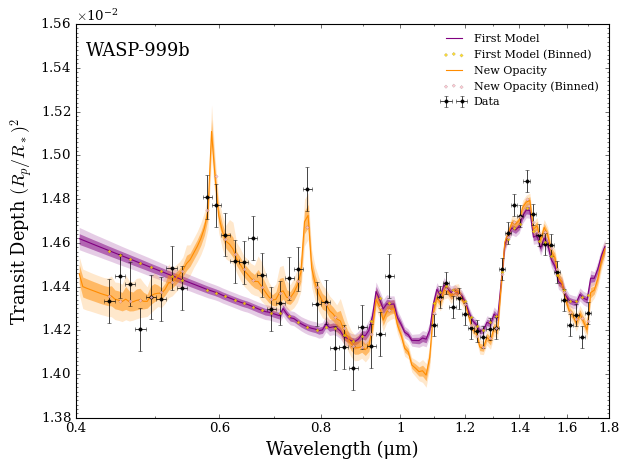

In [10]:
#***** Plot retrieved transmission spectrum *****#

# (TBD: make below dictionaries?)

# Read retrieved spectrum confidence regions
wl, spec_low2, spec_low1, spec_median, \
spec_high1, spec_high2 = read_retrieved_spectrum(planet_name, model_name_2)

# Create composite spectra objects for plotting
spectra_median = plot_collection(spec_median, wl, collection = spectra_median)
spectra_low1 = plot_collection(spec_low1, wl, collection = spectra_low1) 
spectra_low2 = plot_collection(spec_low2, wl, collection = spectra_low2) 
spectra_high1 = plot_collection(spec_high1, wl, collection = spectra_high1) 
spectra_high2 = plot_collection(spec_high2, wl, collection = spectra_high2)

# Produce figure
fig_spec = plot_spectra_retrieved(spectra_median, spectra_low2, spectra_low1, 
                                  spectra_high1, spectra_high2, planet_name,
                                  data, R_to_bin = 100, 
                                  spectra_labels = ['First Model', 'New Opacity'])


Now that looks like a much better fit! Checking the results file, you see that the Bayesian evidence for this new model is significantly higher and the reduced $\chi^2$ is now much closer to 1.

![improved_retrieval_stats](notebook_images/WASP-999b_improved_model_stats.png)

In fact, given that the reduced $\chi^2 < 1$, this suggests a degree of *over fitting*. To see what is going on, you create a corner plot to visualise the retrieved parameters. 

Generating corner plot ...


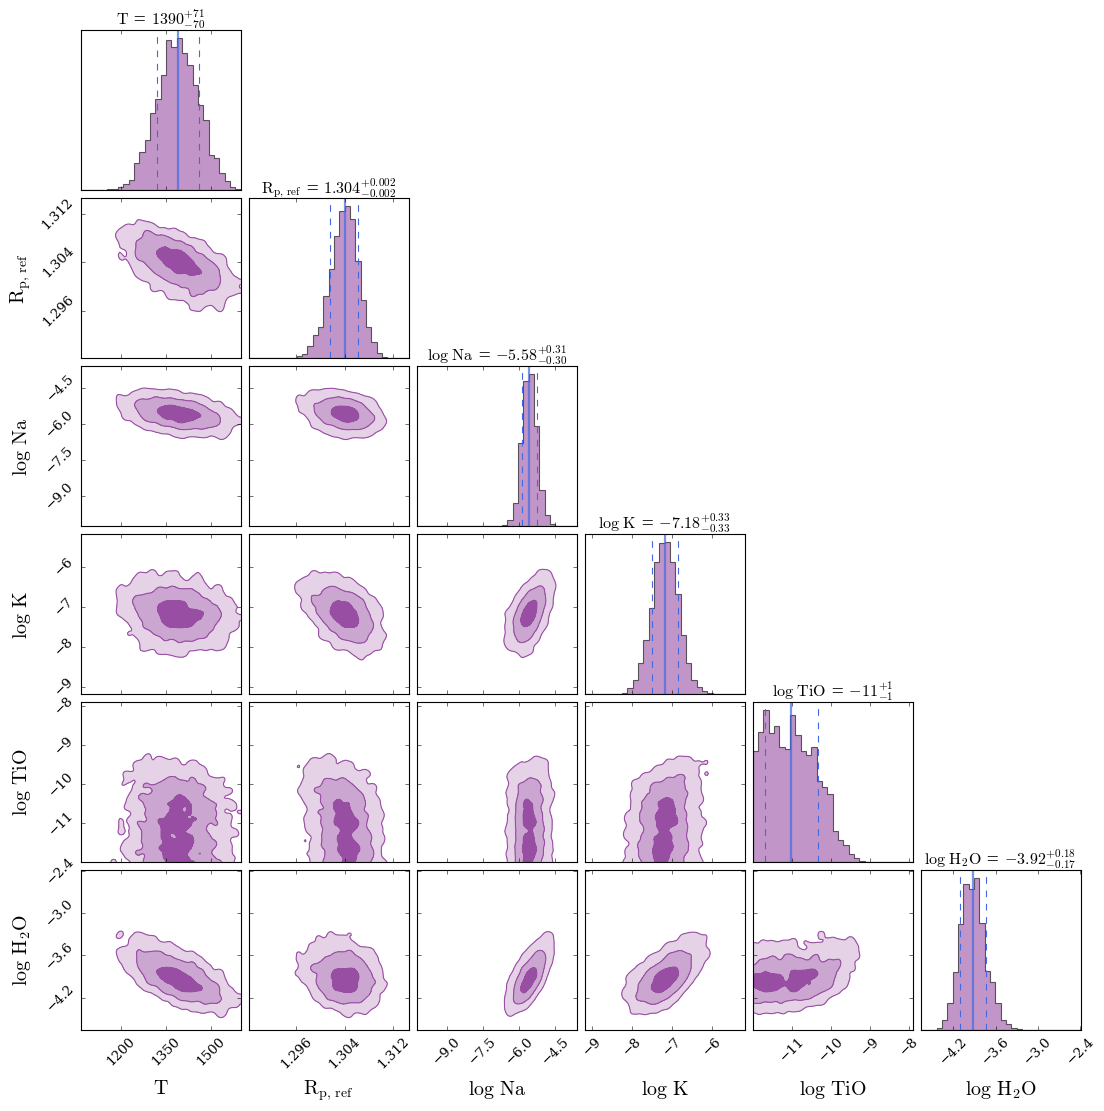

In [11]:
fig_corner = generate_cornerplot(planet, model_2)

### Bayesian Model Comparison

TBD